## S2 Conditional GAN - 7/12/19

As mentioned before, s1 and s2 are important characteristics to correctly model. Therefore the following script will create a conditional GAN, using s1 for dark matter at 50KeV and 200KeV

In [0]:
pip install uproot

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd gdrive/My\ Drive/Masters_Project/dark_matter_7_12_19/in

/content/gdrive/My Drive/Masters_Project/dark_matter_7_12_19/in


Here we will extract some root files, most will be used to train the GAN, then one will be used to 'validate' the GAN.

Currently, we will use 50, 150, and 250 to train and 100 and 200 to validate.

In [0]:
import uproot
import pandas
import numpy as np
import matplotlib.pyplot as plt

tree50 = uproot.open("dark_matter_runs_50kev.root")["dstree"]
tree100 = uproot.open("dark_matter_runs_100kev.root")["dstree"]
tree150 = uproot.open("dark_matter_runs_150kev.root")["dstree"]

The Variable is input here to try to make the code reusable and as general as possible.

In [0]:
#VARIABLE
var = "s1_corr"
cvar = "s2"

rangemin = 350
rangemax = 1800

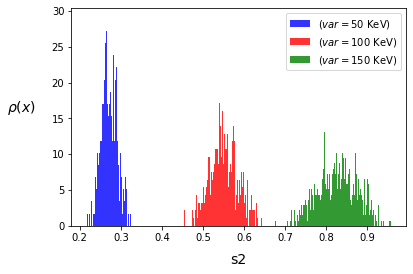

In [0]:

train_var = [50., 100., 150.]
train_DS_ene_50 = np.array(tree50.array(f"{var}"))/rangemax
train_DS_ene_100 = np.array(tree100.array(f"{var}"))/rangemax
train_DS_ene_150 = np.array(tree150.array(f"{var}"))/rangemax

cond_DS_ene_50 = np.array(tree50.array(f"{cvar}"))/22000
cond_DS_ene_100 = np.array(tree100.array(f"{cvar}"))/22000
cond_DS_ene_150 = np.array(tree150.array(f"{cvar}"))/22000

#e_50 = plt.hist(train_DS_ene_50*rangemax,range = (rangemin,rangemax), density = True, bins = 205, alpha = 0.8,color = 'blue',label=r"($var="+f"{train_var[0]:.0f}"+r"~{\rm KeV}$)")
#e_100 = plt.hist(train_DS_ene_100*rangemax,range = (rangemin,rangemax), density = True, bins = 205, alpha = 0.8,color = 'red',label=r"($var="+f"{train_var[1]:.0f}"+r"~{\rm KeV}$)")
#e_150 = plt.hist(train_DS_ene_150*rangemax,range = (rangemin,rangemax), density = True, bins = 205, alpha = 0.8,color = 'green',label=r"($var="+f"{train_var[2]:.0f}"+r"~{\rm KeV}$)")

e_50 = plt.hist(train_DS_ene_50, density = True, bins = 205, alpha = 0.8,color = 'blue',label=r"($var="+f"{train_var[0]:.0f}"+r"~{\rm KeV}$)")
e_100 = plt.hist(train_DS_ene_100, density = True, bins = 205, alpha = 0.8,color = 'red',label=r"($var="+f"{train_var[1]:.0f}"+r"~{\rm KeV}$)")
e_150 = plt.hist(train_DS_ene_150, density = True, bins = 205, alpha = 0.8,color = 'green',label=r"($var="+f"{train_var[2]:.0f}"+r"~{\rm KeV}$)")

plt.xlabel("s2", size=14, labelpad=10)
plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
plt.legend(loc="upper right", fontsize=10)



In [0]:
num_train = int(1e3)
noise_size = 100

# Length needs to be followed through
train_var = [50, 100, 150]

In [0]:
from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate
from keras.models     import Model, Sequential
from keras.optimizers import Adam, SGD

import keras.backend as K
d_do = 0.2
d_nodes = 80

g_do = 0.2
g_nodes = 80

#Input of GEN VALUE
d1_in = Input((1,))
d1 = Dense(d_nodes, activation="relu")(d1_in)
d1 = Dropout(d_do)(d1)
#d1 = BatchNormalization()(d1)

#Input of parameter = energy
hyper_in = Input((1,))
d2 = Dense(d_nodes, activation="relu")(hyper_in)
d2 = Dropout(d_do)(d2)
#d2 = BatchNormalization()(d2)

#Input of parameter = s1
hyper_in2 = Input((1,))
d3 = Dense(d_nodes, activation="relu")(hyper_in2)
d3 = Dropout(d_do)(d3)
#d3 = BatchNormalization()(d3)

dc = Concatenate()([d1, d2, d3])
#dc = Dense(d_nodes , activation="relu")(dc)
#dc = BatchNormalization()(dc)
#dc = Dropout(d_do)(dc)
#dc = LeakyReLU(0.2)(dc)
dc = Dense(d_nodes , activation="relu")(dc)
#dc = BatchNormalization()(dc)
dc = Dropout(d_do)(dc)
dc = LeakyReLU(0.2)(dc)
dc = Dropout(d_do)(dc)
dc = Dense(2, activation="softmax")(dc)

dc = Model(name="Discriminator", inputs=[d1_in, hyper_in,hyper_in2], outputs=[dc])
dc.compile(loss="categorical_crossentropy", optimizer=Adam(0.0005, beta_1=0.5), metrics=["accuracy"])
# 0.0005, beta_1=0.5
dc.summary()

#INPUT OF NOISE TO GENERATOR
g1_in = Input((noise_size,))
g1 = Dense(g_nodes, activation="relu")(g1_in)
g1 = Dropout(g_do)(g1)
g1 = Dense(g_nodes, activation="relu")(g1)
g1 = BatchNormalization()(g1)

#INPUT OF HYPERPARAM
g2 = Dense(g_nodes, activation="relu")(hyper_in)
g2 = Dropout(g_do)(g2)
g2 = BatchNormalization()(g2)

g3 = Dense(g_nodes, activation="relu")(hyper_in2)
g3 = Dropout(g_do)(g3)
g3 = BatchNormalization()(g3)

gc = Concatenate()([g1, g2, g3])
#gc = BatchNormalization()(gc)
#gc = Dropout(0.2)(gc)
gc = Dense(g_nodes, activation="relu")(gc)
#gc = BatchNormalization()(gc)
gc = Dropout(0.2)(gc)
#gc = Dense(g_nodes, activation="relu")(gc)
#gc = BatchNormalization()(gc)
#gc = Dropout(g_do)(gc)
gc = Dense(1, activation="sigmoid")(gc)

gc = Model(name="Generator", inputs=[g1_in, hyper_in, hyper_in2], outputs=[gc])
gc.summary()


gan_out = dc([gc([g1_in, hyper_in, hyper_in2]), hyper_in, hyper_in2])
gan = Model([g1_in, hyper_in, hyper_in2], gan_out, name="GAN")
dc.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0005, beta_1=0.5, beta_2= 0.8), metrics=["accuracy"])
gan.summary()

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 80)           160        

In [0]:
#  Train GAN

epochs     = 1000
batch_size = 1000
rel_batch_size = 1
max_D_itrs_per_G_itr_e80 = 2
max_D_itrs_per_G_itr_e52 = 3

In [0]:
def plot_points_GAN (gen_data, train_data, epoch, batch_size, d_acc) :

    #Needs to be changed depending on number of examples
    gen_class_length = int(gen_data.shape[0]/3)
    gen_data_1 = gen_data[:gen_class_length                    ,0]
    gen_data_2 = gen_data[gen_class_length  :2*gen_class_length,0]
    gen_data_3 = gen_data[2*gen_class_length:3*gen_class_length,0]
    tr_class_length = int(train_data.shape[0]/3)
    train_data_1 = train_data[:tr_class_length                   ,0]
    train_data_2 = train_data[tr_class_length  :2*tr_class_length,0]
    train_data_3 = train_data[2*tr_class_length:3*tr_class_length,0]


    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1, 2, 1)
    h0 = plt.hist(gen_data_115, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue"  , density=True, label=r"Generated data ($var="+f"{train_var[0]:.0f}"+r"~{\rm KeV}$)")
    h1 = plt.hist(gen_data_130, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="purple", density=True, label=r"Generated data ($var="+f"{train_var[1]:.0f}"+r"~{\rm KeV}$)")
    h2 = plt.hist(gen_data_145, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="red"   , density=True, label=r"Generated data ($var="+f"{train_var[2]:.0f}"+r"~{\rm KeV}$)")
    plt.legend(loc="upper right", fontsize=10)
    plt.xlabel("x", size=14, labelpad=10)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    #y_max = 1.5*np.max([max(h0[0]), max(h1[0]), max(h2[0])])
    y_max = 1
    if np.isnan(y_max) : y_max = 1.0
    plt.gca().set_ylim([0, y_max])
    plt.text(range_min+0.*1.1*range_width   , 0.88*y_max, "Conditional", size=14, style="italic", weight="bold")
    plt.text(range_min+0.*1.1*range_width   , 0.80*y_max, "GAN test", size=18, style="italic", weight="bold")
    plt.text(range_min+0.780*1.1*range_width, 0.68*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.713*1.1*range_width, 0.61*y_max, f"Batch size: {gen_class_length}")
    plt.text(range_min+0.810*1.1*range_width, 0.54*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    fig.add_subplot(1, 2, 2)
    h0_2 = plt.hist(train_data_115, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue"  , density=True, label=r"Training data ($m="+f"{train_var[0]:.0f}"+r"~{\rm GeV}$)")
    h1_2 = plt.hist(train_data_130, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="purple", density=True, label=r"Training data ($m="+f"{train_var[1]:.0f}"+r"~{\rm GeV}$)")
    h2_2 = plt.hist(train_data_145, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="red"   , density=True, label=r"Training data ($m="+f"{train_var[2]:.0f}"+r"~{\rm GeV}$)")
    plt.legend(loc="upper right", fontsize=10)
    plt.xlabel("x", size=14, labelpad=10)
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    #y_max = 1.5*np.max([max(h0_2[0]), max(h1_2[0]), max(h2_2[0])])
    y_max = 1
    if np.isnan(y_max) : y_max = 1.0
    plt.gca().set_ylim([0, y_max])
    plt.text(range_min+0.780*1.1*range_width, 0.68*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.713*1.1*range_width, 0.61*y_max, f"Batch size: {tr_class_length}")
    plt.text(range_min+0.810*1.1*range_width, 0.54*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    #plt.savefig(f"out/1D_GAN_test/Train_epoch{epoch}.png", dpi=96)
    plt.show()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




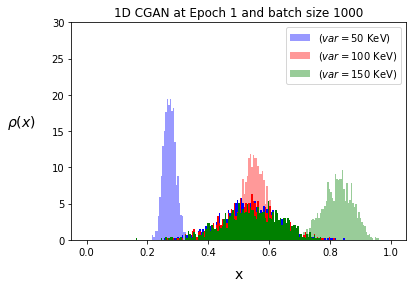

973.3399989451162
SAVING


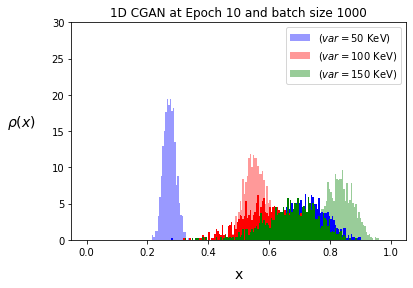

907.739977088971
SAVING


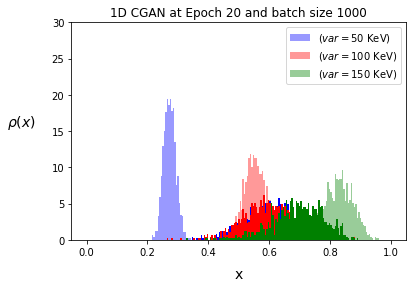

876.1699419715571
SAVING


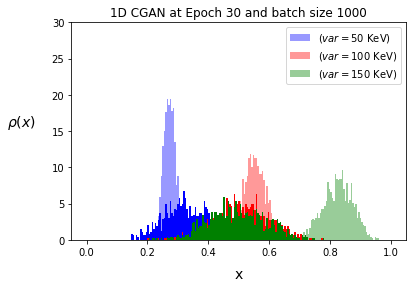

876.1699388390925
SAVING


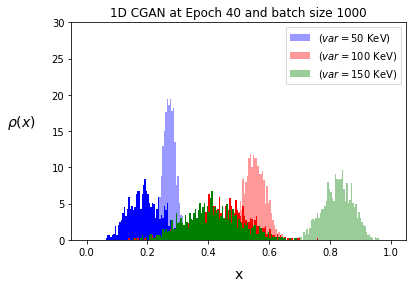

993.8399965765066


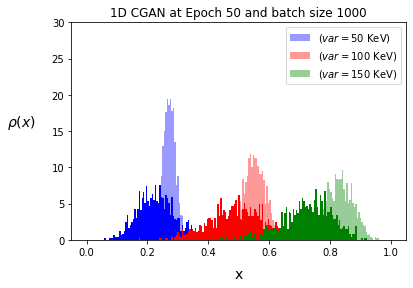

707.6599144939422
SAVING


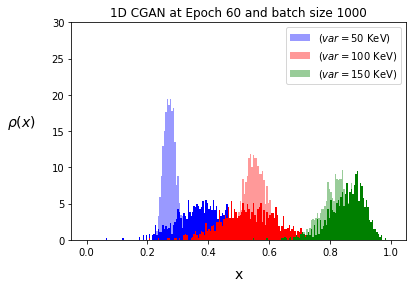

642.8799881340285
SAVING


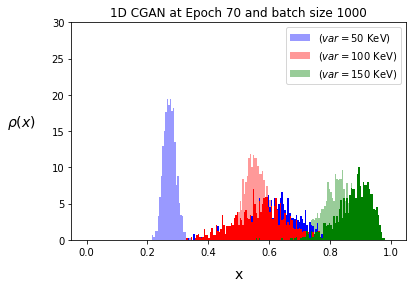

777.7700159554463


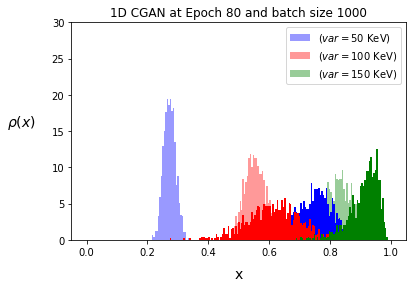

900.7700155293076


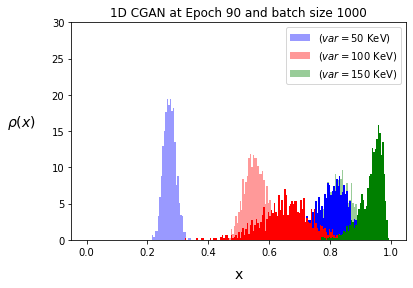

1022.5399650852459


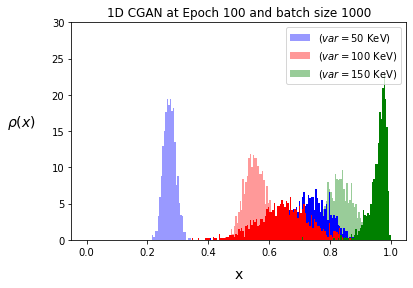

1054.9299847029113


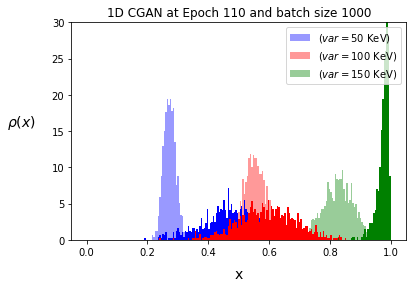

984.40998883758


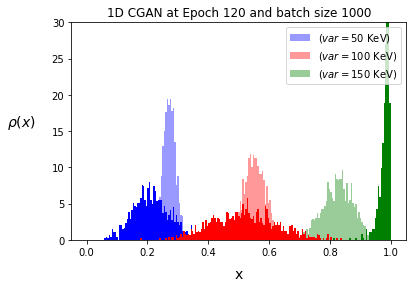

898.31008973695


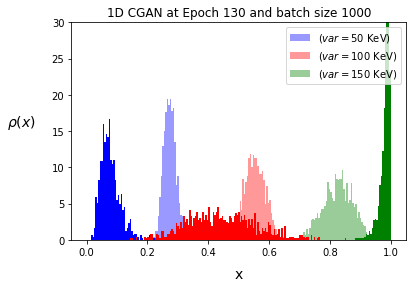

1086.9100356680046


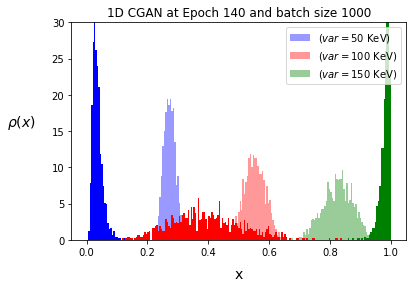

1134.0600349199206


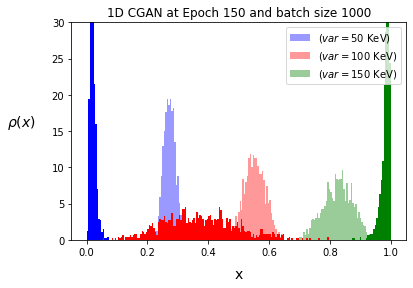

1148.0000934190411


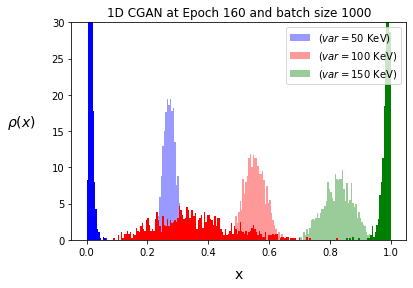

1154.9700479726655


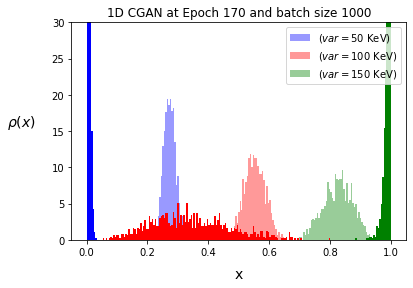

1163.5801069071563


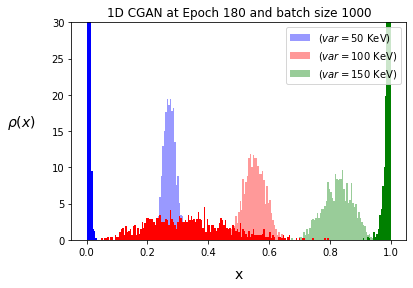

1169.7301378601614


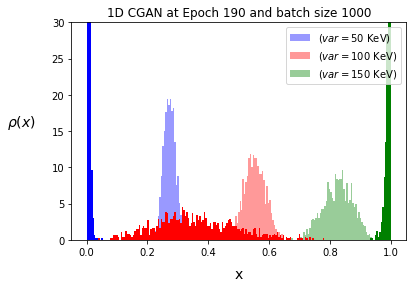

1158.2501407669743


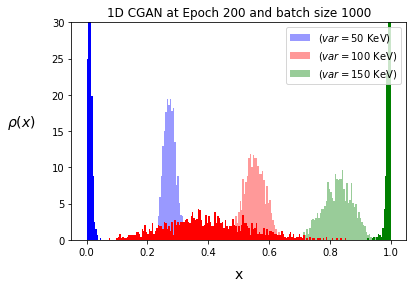

1131.1901812611313


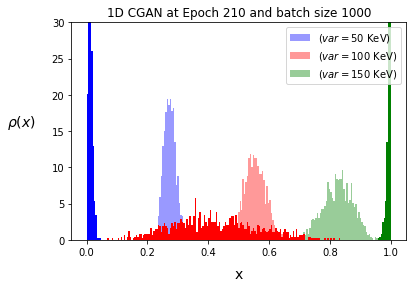

1122.9901575899332


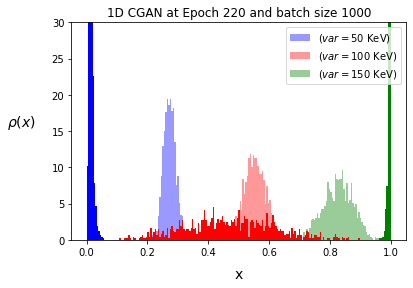

1088.1402038447948


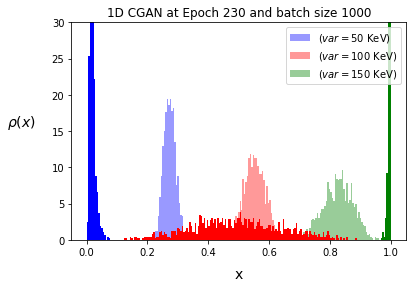

1091.0101667781782


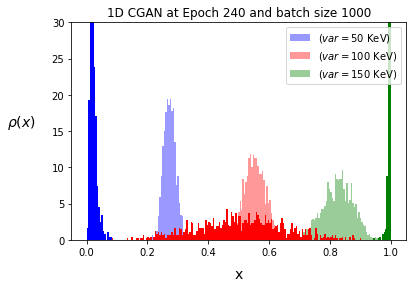

1071.740165817424


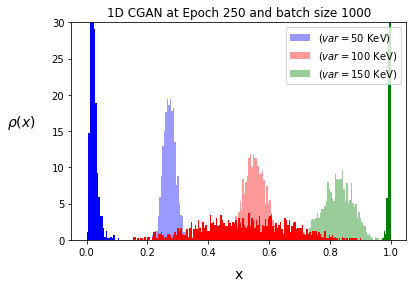

1084.0401449061958


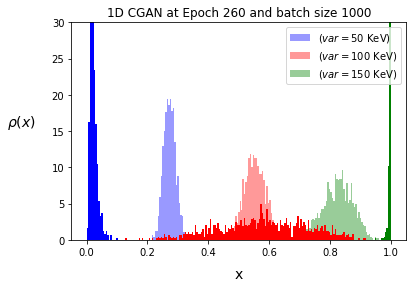

1072.1501498879127


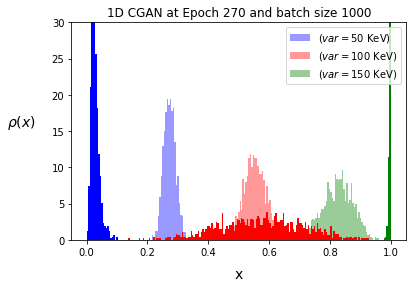

1075.0201979082044


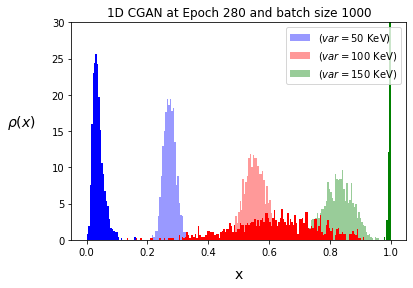

1086.9101913220884


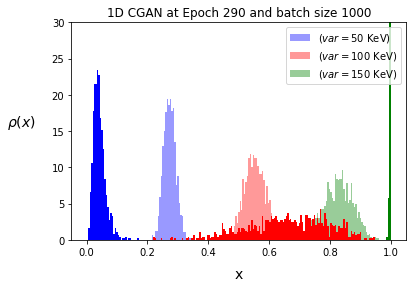

1113.1501463670984


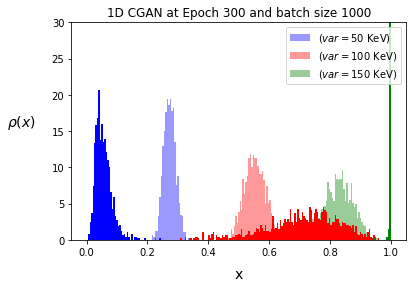

1154.9701572090846


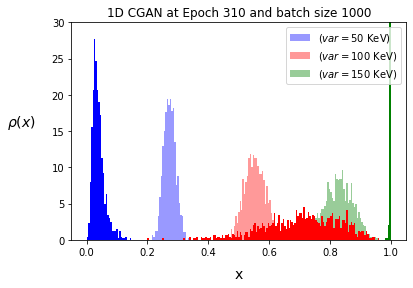

1141.4401882974435


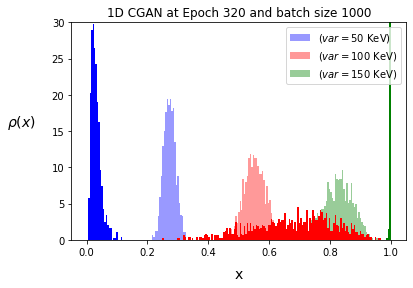

1121.760184871352


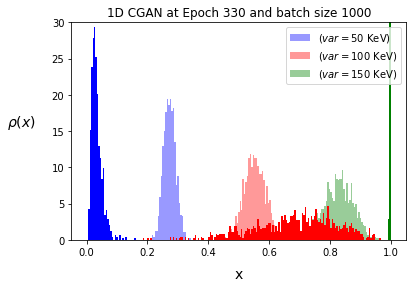

1132.8301773857772


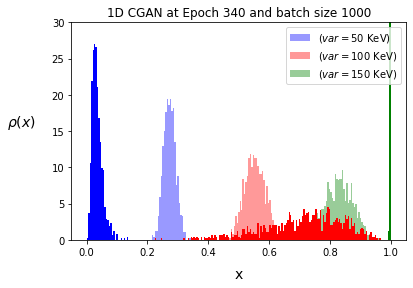

1148.0001778022695


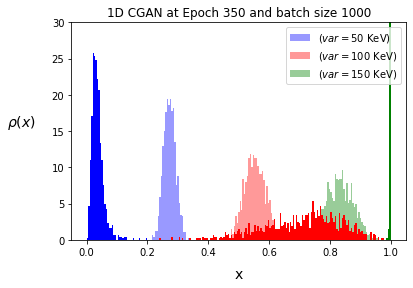

1138.1601671266233


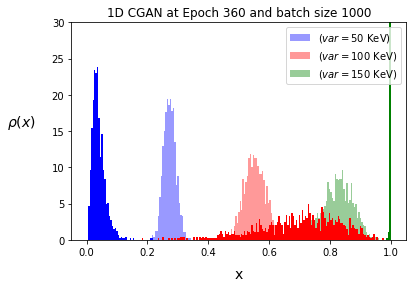

1142.260144657383


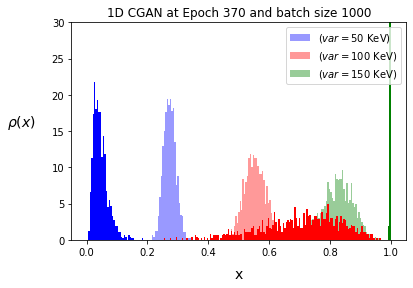

1142.2601725239153


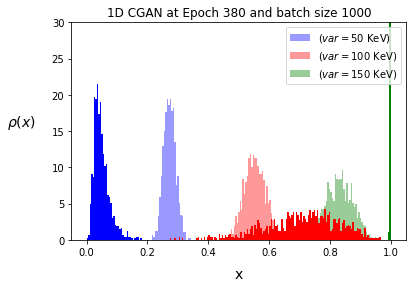

1144.7201574533137


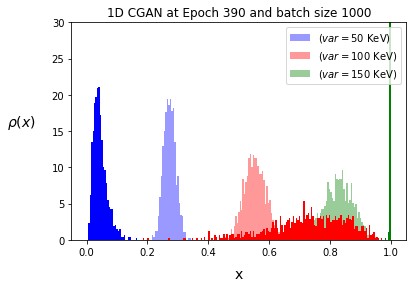

1161.940196693369


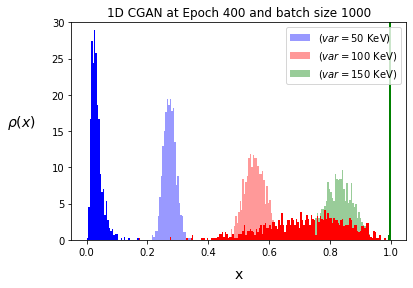

1143.4901524447694


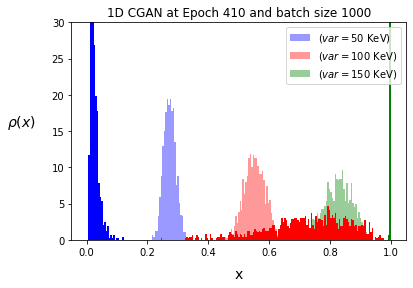

1156.2001549378951


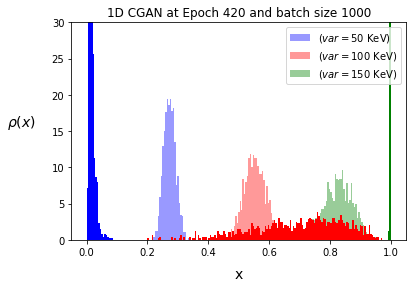

1137.7501566377796


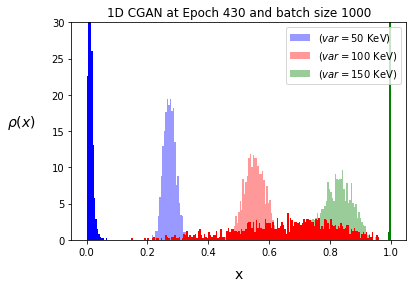

1116.020189729739


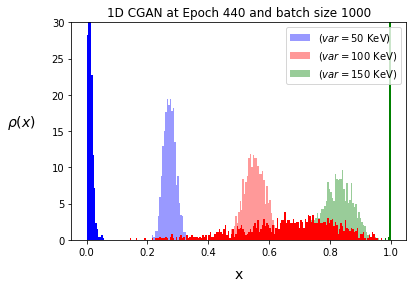

1129.1401546495601


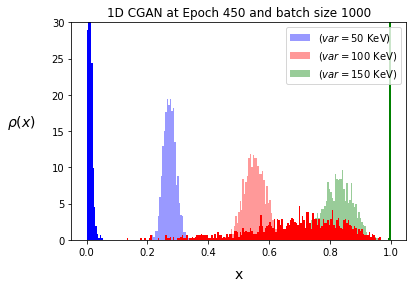

1138.5701971452927


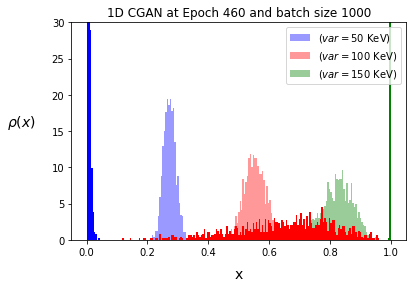

1123.8101842040774


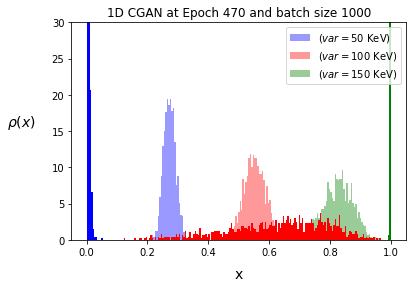

1120.1201561450657


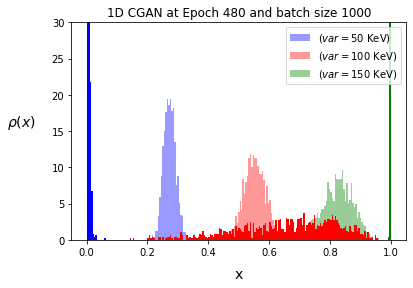

1128.7301756281415


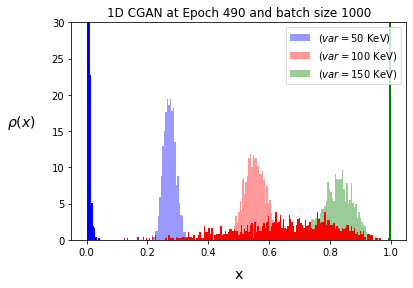

1123.400179312125


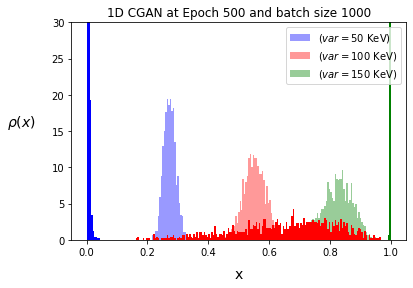

1126.2701433803275


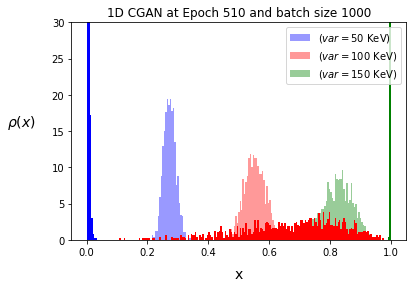

1130.3701797753822


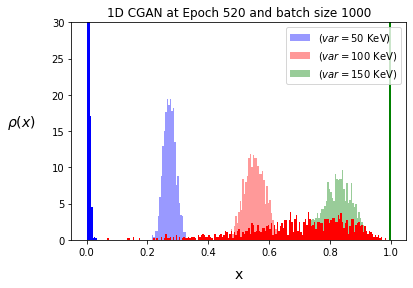

1141.8501454795544


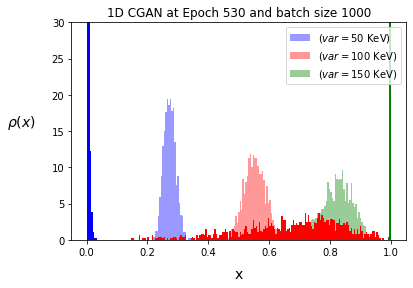

1136.1101596137564


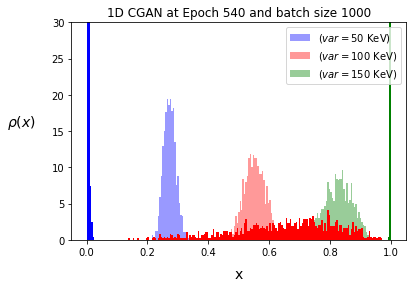

1124.6301411117984


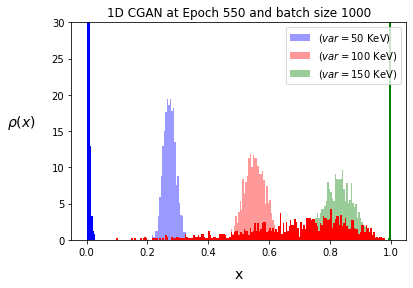

1137.7501539372038


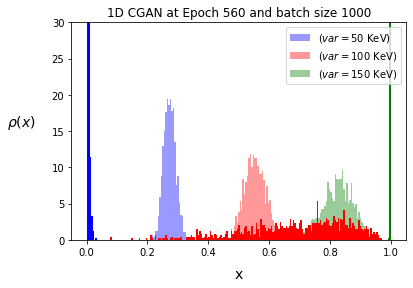

1135.7001643107649


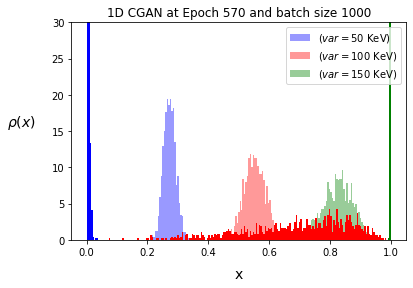

1145.9501821093254


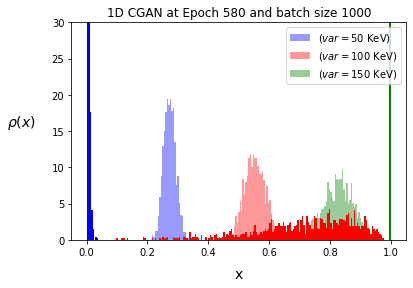

1156.6101802208257


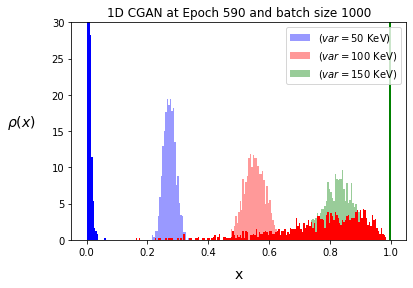

1173.8301967606426


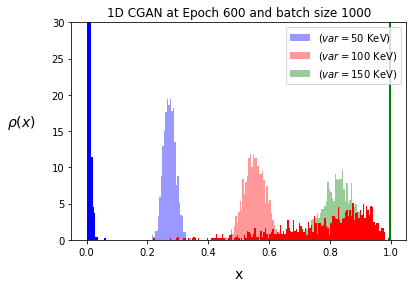

1182.4401713127509


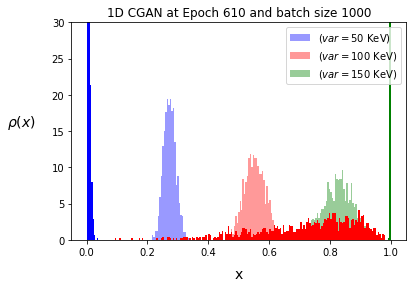

1154.5601719254591


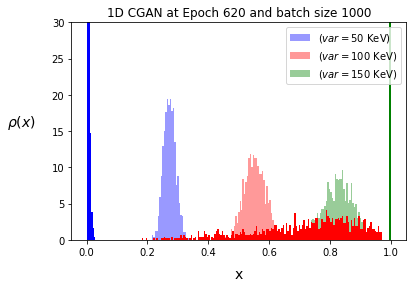

1158.2501601804702


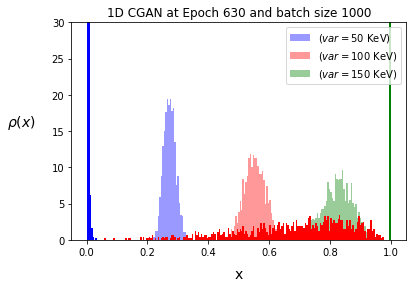

1147.1801264141372


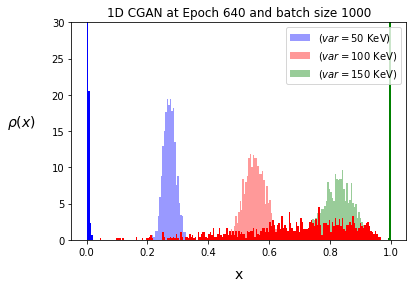

1148.4101776452317


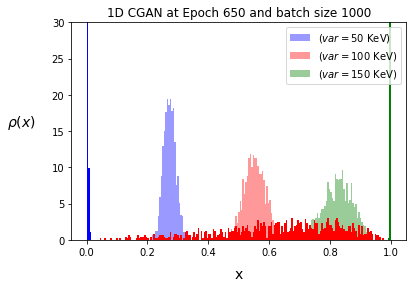

1128.320131088926


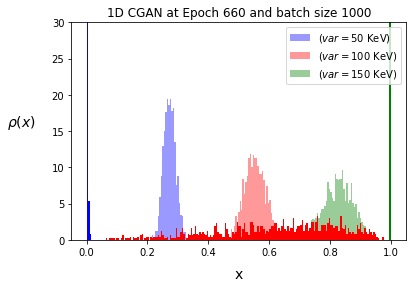

1132.8301563680852


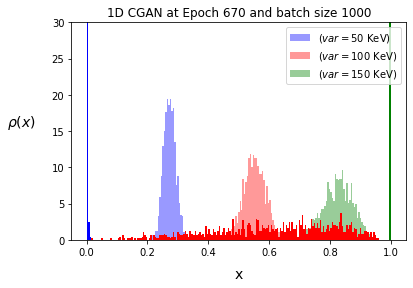

1132.8301755850518


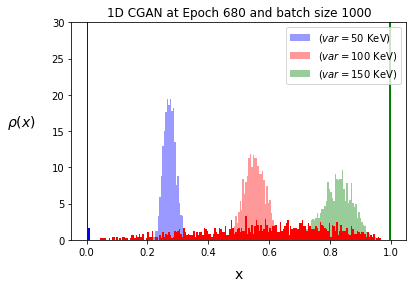

1124.6301549666364


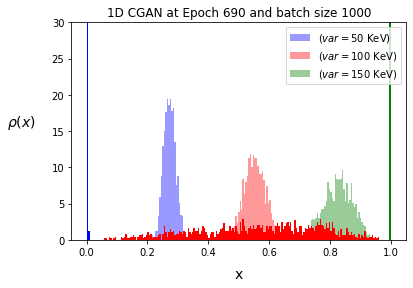

1125.860172734358


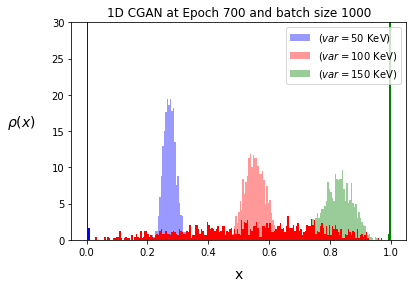

1127.910201303384


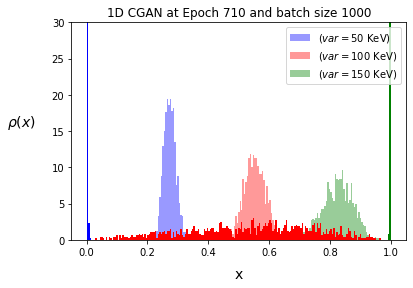

1121.7601551256332


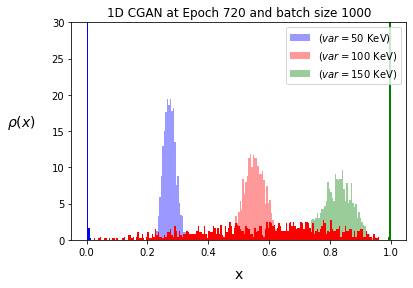

1129.9601612239053


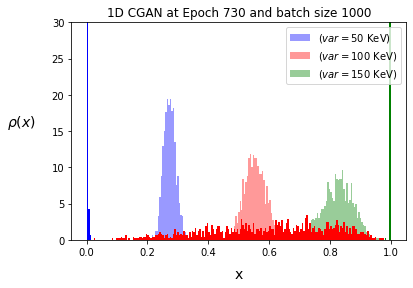

1133.2401424344628


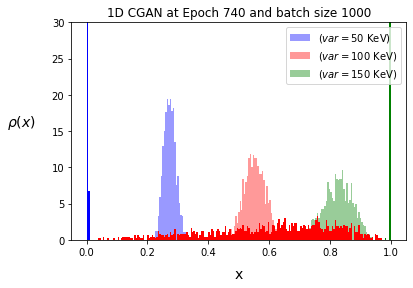

1135.2901925298315


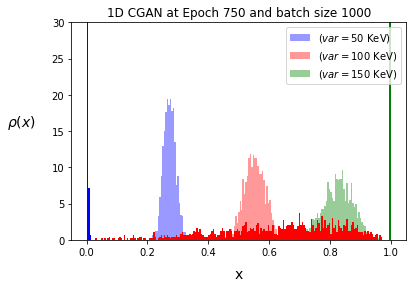

1135.290164584999


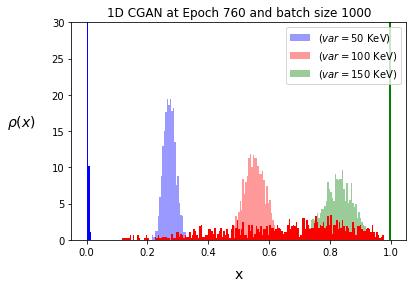

1140.620160353099


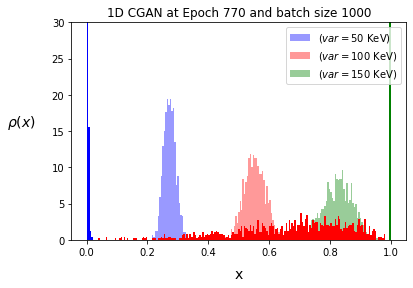

1136.5201396918922


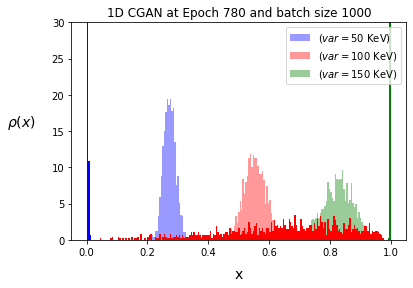

1138.5701898654204


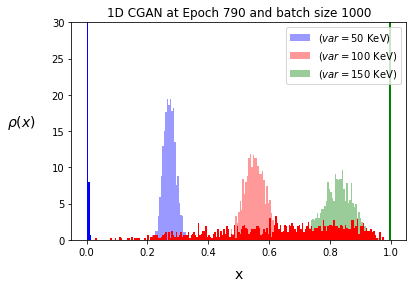

1138.5701735055197


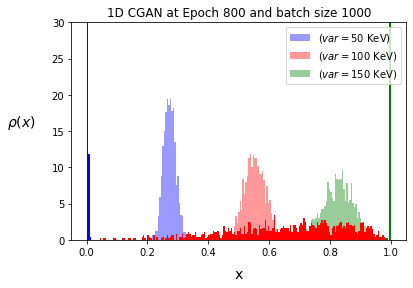

1134.0601345278308


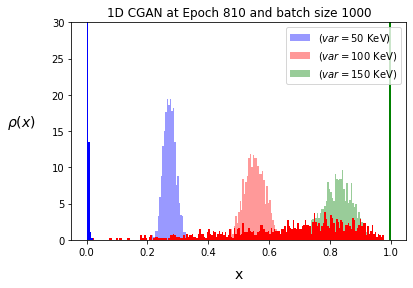

1148.4101453951735


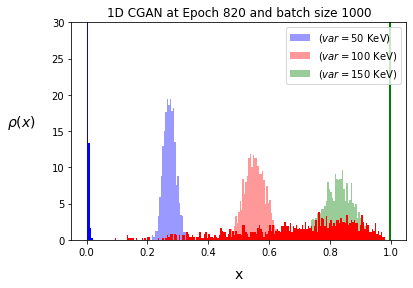

1152.5101244131602


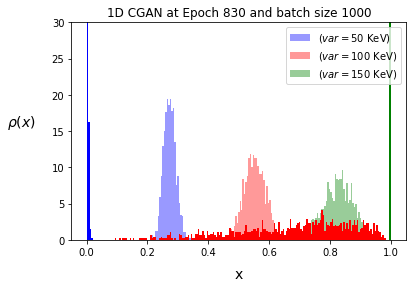

1147.5902001897252


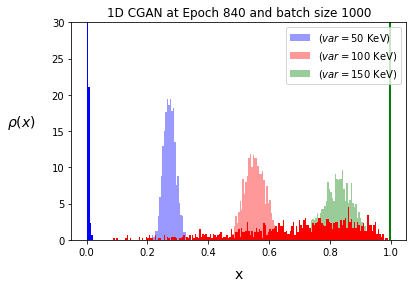

1148.000171461697


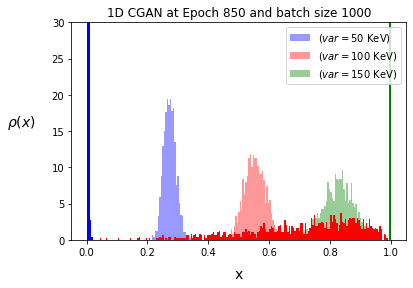

1154.9701660542542


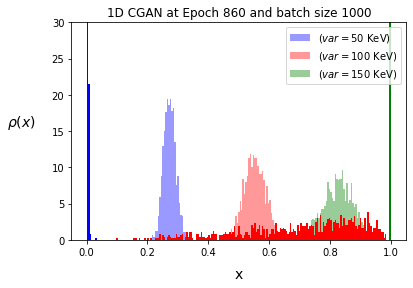

1153.7401916127694


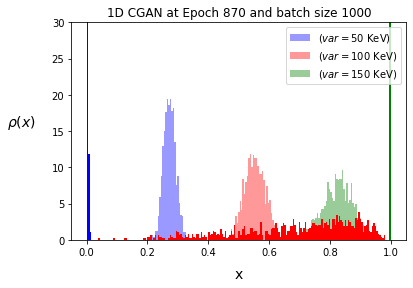

1154.5601728647084


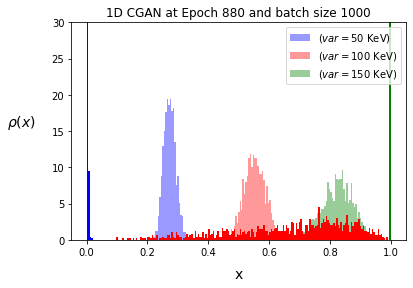

1152.5101660564176


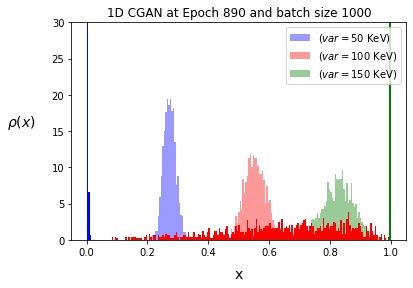

1130.7801854107947


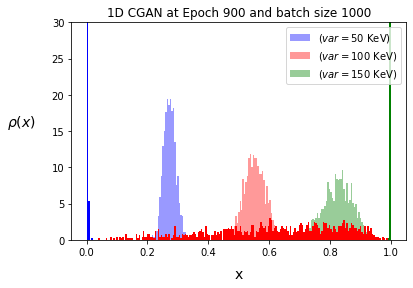

1131.60014220108


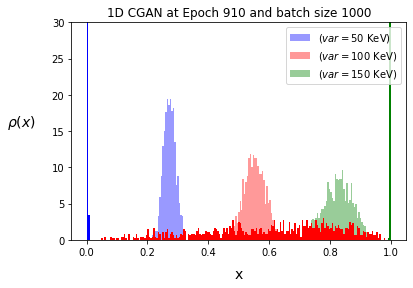

1142.2601719364852


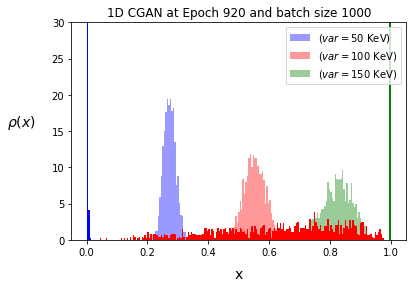

1146.7701688796487


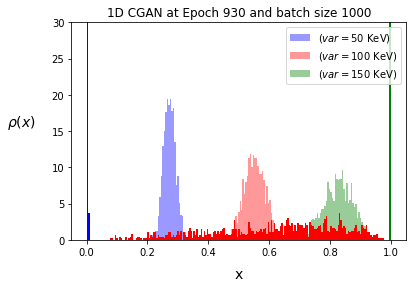

1142.6701216041574


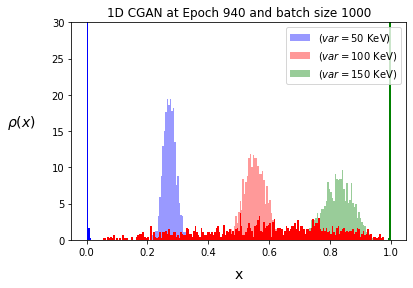

1121.3501620144482


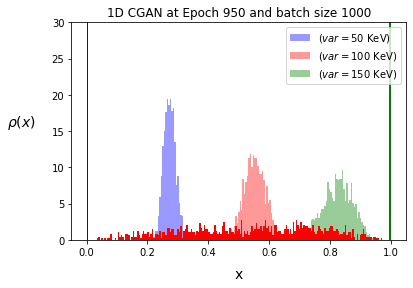

1134.060137501978


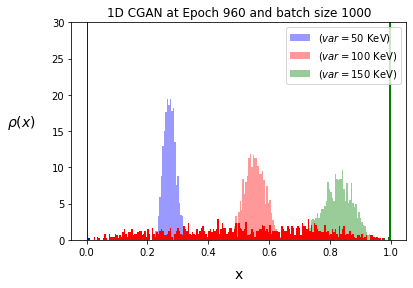

1139.390152761167


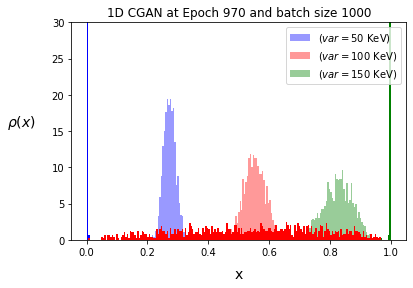

1139.390180275506


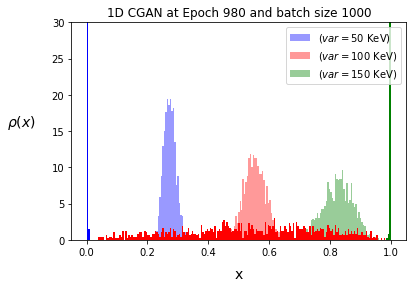

1135.7001581656332


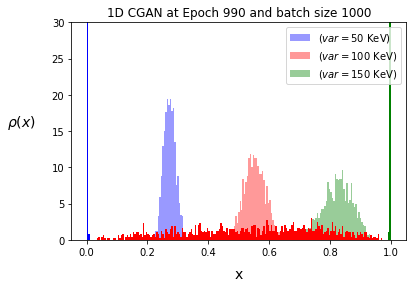

1136.1101890847099


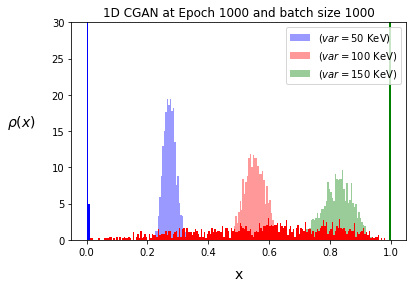

1126.6801407183657


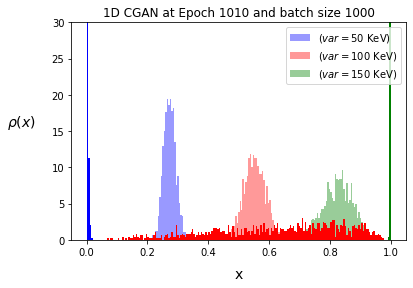

1145.5401340474364


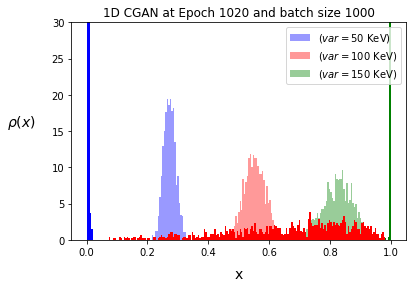

1143.0801699006747


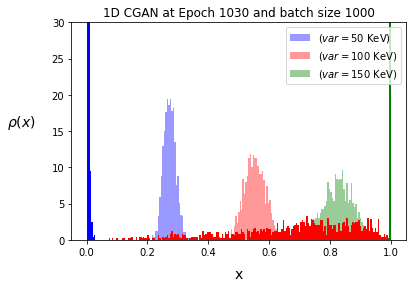

1154.9701990479105


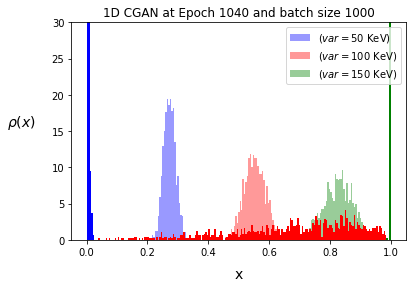

1149.640160462333


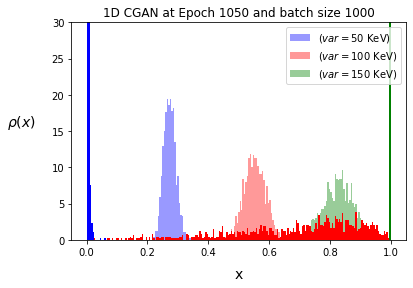

1152.5101695398039


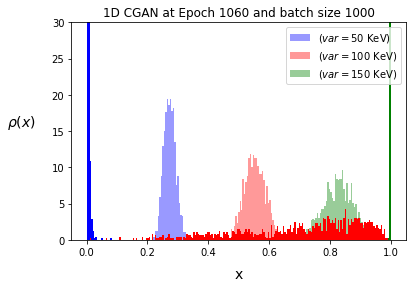

1164.4001639320236


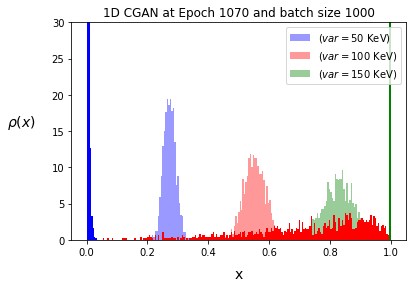

1160.7101615871993


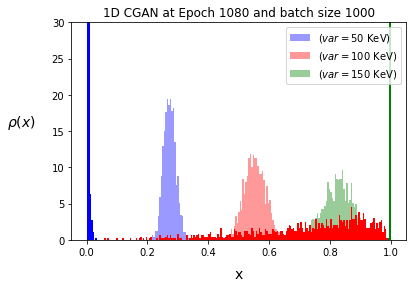

1161.5301580639834


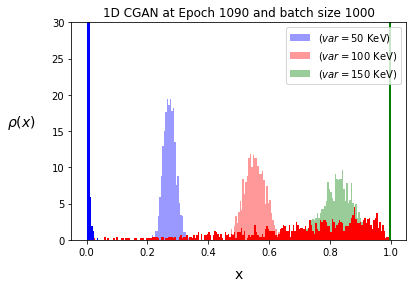

1166.8601775891334


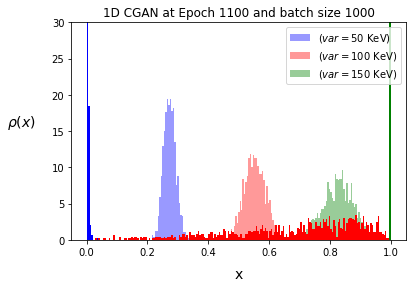

1157.8401858555703


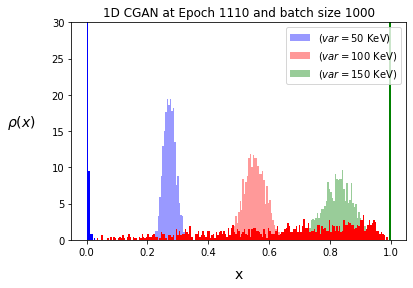

1157.840153096651


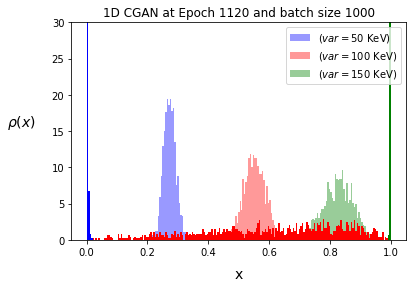

1145.5401818746554


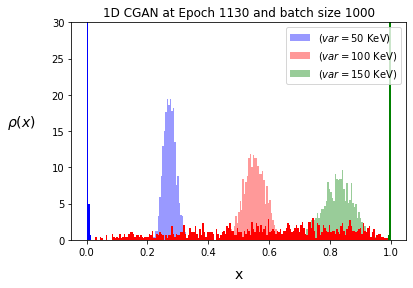

1142.6701724840568


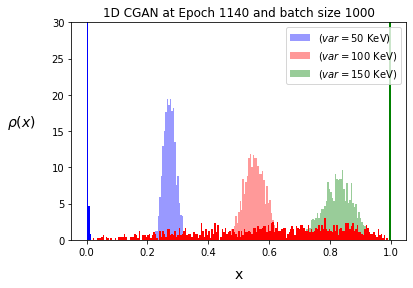

1142.2601608211103


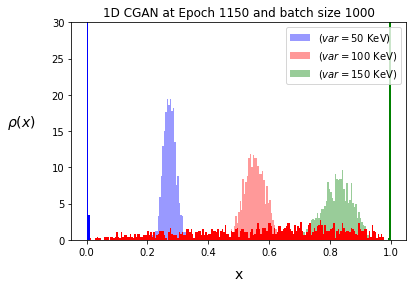

1142.2601499014916


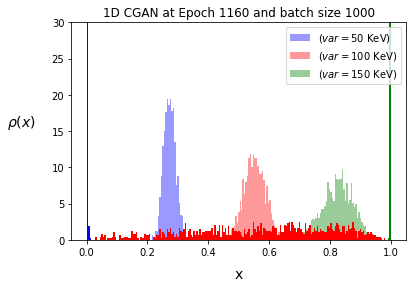

1147.1801556502737


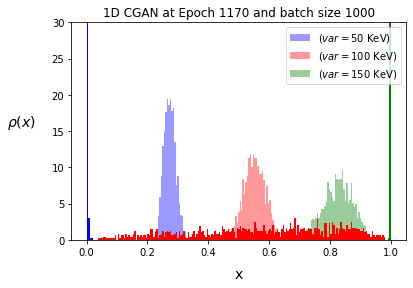

1140.2101546391614


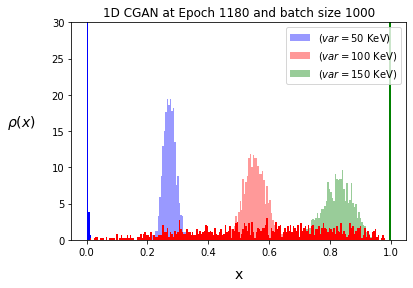

1138.160196245099


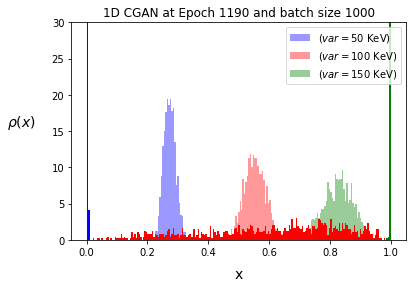

1141.440170997928


KeyboardInterrupt: ignored

In [0]:
#  Train GAN
range_min, range_max = 0, 70
range_width = 70
plot_resolution = 200
epochs     = 10000
batch_size = 1000
minloss = 1000000
real_loss = []
real_acc = []
epoch_no = []

def update_batch_size (gen_DS, e) :
    global batch_size
    #batch_size = min(max(batch_size, 100+int((e+1)/10.)), num_train)
    
def get_noise () :
    hyperparams = np.concatenate([np.full(fill_value=train_var[0], shape=(batch_size, 1)),
                                  np.full(fill_value=train_var[1], shape=(batch_size, 1)),
                                  np.full(fill_value=train_var[2], shape=(batch_size, 1))])
    param2 = np.concatenate([cond_DS_ene_50,cond_DS_ene_100,cond_DS_ene_150])
    return np.random.normal(size=(3*batch_size, noise_size)), hyperparams, param2

def get_train_data () :
    batch_1 = train_DS_ene_50[np.random.randint(0, len(train_DS_ene_50), rel_batch_size*batch_size)].reshape(rel_batch_size*batch_size, 1)
    batch_2 = train_DS_ene_100[np.random.randint(0, len(train_DS_ene_100), rel_batch_size*batch_size)].reshape(rel_batch_size*batch_size, 1)
    batch_3 = train_DS_ene_150[np.random.randint(0, len(train_DS_ene_150), rel_batch_size*batch_size)].reshape(rel_batch_size*batch_size, 1)
    param2 = np.concatenate([cond_DS_ene_50,cond_DS_ene_100,cond_DS_ene_150])
    hyperparams = np.concatenate([np.full(fill_value=train_var[0], shape=(rel_batch_size*batch_size, 1)),
                                  np.full(fill_value=train_var[1], shape=(rel_batch_size*batch_size, 1)),
                                  np.full(fill_value=train_var[2], shape=(rel_batch_size*batch_size, 1))])
    return np.concatenate([batch_1, batch_2, batch_3]), hyperparams, param2
  
epochs_saved = []
for e in range(epochs) :
    noise, noise_hyperparams, noise_param2    = get_noise()
    batch_DS, batch_hyperparams, batch_param2 = get_train_data()
    gen_DS   = gc.predict([noise, noise_hyperparams, noise_param2])
    real_label  = np.array([[1., 0.] for i in range(3*batch_size)])
    fake_label  = np.array([[0., 1.] for i in range(3*batch_size)])
    train_label = np.array([[1., 0.] for i in range(3*batch_size)])
    X  = np.concatenate([batch_DS  , gen_DS    ])
    Xh = np.concatenate([batch_hyperparams  , noise_hyperparams    ])
    Xh2 = np.concatenate([batch_param2  , noise_param2    ])
    Y = np.concatenate([real_label, fake_label])
    W = np.concatenate([np.ones(shape=(batch_DS.shape[0],)), np.full(fill_value=rel_batch_size, shape=(gen_DS.shape[0],))])
    
    dc.trainable = True
    d_loss, d_acc = dc.train_on_batch([X, Xh, Xh2], Y, sample_weight=W)
        
    noise, noise_hyperparams, noise_param2 = get_noise()
    dc.trainable = False
    gan.train_on_batch([noise, noise_hyperparams, noise_param2], train_label)
    
    if e == 0 or (e+1) % 10 == 0 :
        noise, noise_hyperparams, noise_param2 = get_noise()
        gen_DS = gc.predict([noise, noise_hyperparams, noise_param2])
        #plot_points_GAN(
        #            gen_DS,
        #            batch_DS,
        #            epoch=e+1, 
        #            batch_size=batch_size, 
        #            d_acc=dc.evaluate([X, Xh], Y, sample_weight=W, verbose=0)[1])
        #e_50 = plt.hist(train_DS_ene_50*rangemax,range = (rangemin,rangemax), density = True, bins = 205, alpha = 0.4, color='blue', label=r"($var="+f"{train_var[0]:.0f}"+r"~{\rm KeV}$)")
        #e_150 = plt.hist(train_DS_ene_100*rangemax,range = (rangemin,rangemax), density = True, bins = 205, alpha = 0.4, color='red', label=r"($var="+f"{train_var[1]:.0f}"+r"~{\rm KeV}$)")
        #e_250 = plt.hist(train_DS_ene_150*rangemax,range = (rangemin,rangemax), density = True, bins = 205, alpha = 0.4, color='green', label=r"($var="+f"{train_var[2]:.0f}"+r"~{\rm KeV}$)")

        e_50 = plt.hist(train_DS_ene_50, density = True, range = (0,1),bins = 205, alpha = 0.4, color='blue', label=r"($var="+f"{train_var[0]:.0f}"+r"~{\rm KeV}$)")
        e_150 = plt.hist(train_DS_ene_100, density = True,range = (0,1), bins = 205, alpha = 0.4, color='red', label=r"($var="+f"{train_var[1]:.0f}"+r"~{\rm KeV}$)")
        e_250 = plt.hist(train_DS_ene_150, density = True,range = (0,1), bins = 205, alpha = 0.4, color='green', label=r"($var="+f"{train_var[2]:.0f}"+r"~{\rm KeV}$)")


        gen_class_length = int(gen_DS.shape[0]/3)
        gen_data_115 = gen_DS[:gen_class_length                    ,0]
        gen_data_130 = gen_DS[gen_class_length  :2*gen_class_length,0]
        gen_data_145 = gen_DS[2*gen_class_length:3*gen_class_length,0]
        
        #gen_50 = plt.hist(gen_data_115*rangemax,range = (rangemin,rangemax), density = True, bins = 205, color='blue')
        #gen_150 = plt.hist(gen_data_130*rangemax,range = (rangemin,rangemax), density = True, bins = 205, color='red')
        #gen_250 = plt.hist(gen_data_145*rangemax,range = (rangemin,rangemax), density = True, bins = 205, color='green')

        gen_50 = plt.hist(gen_data_115,range = (0,1), density = True, bins = 205, color='blue')
        gen_150 = plt.hist(gen_data_130,range = (0,1), density = True, bins = 205, color='red')
        gen_250 = plt.hist(gen_data_145,range = (0,1), density = True, bins = 205, color='green')

        plt.legend(loc="upper right", fontsize=10)
        plt.xlabel("x", size=14, labelpad=10)
        plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
        plt.ylim(top=30)
        plt.title(f"1D CGAN at Epoch {e+1} and batch size {batch_size}")
        #plt.text(50,0.85,f"Epochs: {epochs}")
        #plt.text(50,0.75,f"Batch Size: {batch_size}")
        plt.show()
        epoch_no.append(e)
        real_loss.append(d_loss)
        real_acc.append(d_acc)

        diffs1_150 = e_50[0] - gen_50[0]
        diffs1_100 = e_150[0] - gen_150[0]
        diffs1_50 = e_250[0] - gen_250[0]

        sum_diff = 0
        for i in range(len(diffs1_50)):
          sum_diff += abs(diffs1_50[i])+ abs(diffs1_100[i]) +  abs(diffs1_150[i])
        #If statement
        print(sum_diff)
        if sum_diff < minloss:
          #save weights
          print("SAVING")
          gc.save("2D_s1_s2.h5")
          minloss = sum_diff
          
        update_batch_size(gen_DS, e)
        epochs_saved.append(e+1)

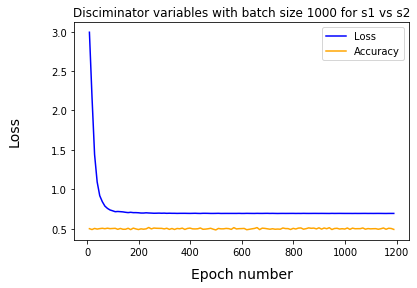

In [0]:
del epoch_no[0]
del real_loss[0]
del real_acc[0]
h3 = plt.plot(epoch_no,real_loss, color = 'blue', label = "Loss")
h4 = plt.plot(epoch_no,real_acc, color = 'orange', label = "Accuracy")
plt.xlabel("Epoch number", size=14, labelpad=10)
plt.ylabel("Loss", size=14, labelpad=30, rotation="vertical")
plt.title(f"Disciminator variables with batch size {batch_size} for s1 vs s2")
plt.legend(loc="upper right", fontsize=10)
plt.show()

In [0]:
mass = 100

hyperparams = np.full(fill_value=mass, shape=(100000, 1))
z = np.random.normal(size=(10000, noise_size))
datapoints = gc.predict([z, hyperparams])[:,0]
s1_true = plt.hist(train_DS_ene_100, density = True, range = (20,30),  bins = 100, alpha = 1, color='red', label = 'G4 Data')
s1_gen = plt.hist(datapoints, density = True, range = (20,30),  bins = 100, alpha = 0.4, color='red', label = 'Generated Data')


plt.legend(loc="upper right", fontsize=10)
plt.xlabel("s1 energy", size=14, labelpad=10)
plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
plt.title("Comparing our CGAN with unseen G4 Data for 200KeV")

#s1_diff = s1_true[0] - s1_gen[0]

#sum_s1_diff = 0
#for i in range(len(s1_diff)):
 # sum_s1_diff += abs(s1_diff[i])

#plt.text(60,0.43,f"Loss: {round(sum_s1_diff)}")

plt.show()

print(f"          MASS = {mass}")
print(f"GENERATED MEAN = {np.mean(datapoints):.1f}")

ValueError: ignored

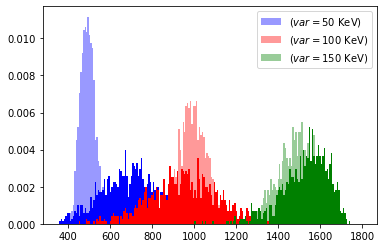

In [0]:
from keras.models     import load_model
final_gc = load_model("2D_s1_s2.h5", compile = False)
gen_DS = final_gc.predict([noise, noise_hyperparams, noise_param2])

e_50 = plt.hist(train_DS_ene_50*rangemax,range = (rangemin,rangemax), density = True, bins = 205, alpha = 0.4, color='blue', label=r"($var="+f"{train_var[0]:.0f}"+r"~{\rm KeV}$)")
e_150 = plt.hist(train_DS_ene_100*rangemax,range = (rangemin,rangemax), density = True, bins = 205, alpha = 0.4, color='red', label=r"($var="+f"{train_var[1]:.0f}"+r"~{\rm KeV}$)")
e_250 = plt.hist(train_DS_ene_150*rangemax,range = (rangemin,rangemax), density = True, bins = 205, alpha = 0.4, color='green', label=r"($var="+f"{train_var[2]:.0f}"+r"~{\rm KeV}$)")

gen_class_length = int(gen_DS.shape[0]/3)
gen_data_115 = gen_DS[:gen_class_length                    ,0]
gen_data_130 = gen_DS[gen_class_length  :2*gen_class_length,0]
gen_data_145 = gen_DS[2*gen_class_length:3*gen_class_length,0]

gen_50 = plt.hist(gen_data_115*rangemax,range = (rangemin,rangemax), density = True, bins = 205, color='blue')
gen_150 = plt.hist(gen_data_130*rangemax,range = (rangemin,rangemax), density = True, bins = 205, color='red')
gen_250 = plt.hist(gen_data_145*rangemax,range = (rangemin,rangemax), density = True, bins = 205, color='green')

plt.legend(loc="upper right", fontsize=10)